In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import statsmodels.api as sm
from arch import arch_model
sns.set()
%matplotlib inline
import warnings
warnings.simplefilter('ignore')


In [2]:
btc      = pd.read_csv('BTCUSDT.csv')
btc      = btc[(btc['Date'] >= '2018-03-31') & (btc['Date'] < '2020-04-30')]
btc.Date = pd.to_datetime(btc.Date)
btc.set_index('Date',inplace=True)
btc['returns']     = btc['Adj.Close'].pct_change()
btc['log_returns'] = np.log(btc['Adj.Close']).diff()
btc_returns       =btc['log_returns']
btc_returns = btc_returns.dropna()
#Ret_100 = 100*sp500['Adj.Close'].pct_change().dropna()


In [16]:
df = pd.DataFrame(btc['Adj.Close'], dtype=float)
df.index.name = 'date'

df['log_price'] = np.log(df['Adj.Close'])
df['return'] = df['Adj.Close'].pct_change().dropna()
df['log_return'] = df['log_price'] - df['log_price'].shift(1)
df['squared_log_return'] = np.power(df['log_return'], 2)

df['return_100x'] = np.multiply(df['return'], 100)
df['log_return_100x'] = np.multiply(df['log_return'], 100)

df['realized_variance'] = df.loc[:, 'squared_log_return'].resample('d', closed='left', label='left').sum().copy()
df['realized_volatility'] = np.sqrt(df['realized_variance']) 
btc_realized_vola=df['realized_volatility']
df= df.dropna() # Remove the forst row due to missing data
df.head()

,Adj.Close,log_price,return,log_return,squared_log_return,return_100x,log_return_100x,realized_variance,realized_volatility
date,,,,,,,,,
2018-04-01,6819.00,8.827468,-0.016413,-0.016549,0.000274,-1.641331,-1.654950,0.000274,0.016549
2018-04-02,6981.36,8.850999,0.023810,0.023531,0.000554,2.380994,2.353091,0.000554,0.023531
2018-04-03,7431.00,8.913416,0.064406,0.062417,0.003896,6.440579,6.241670,0.003896,0.062417
2018-04-04,6818.78,8.827436,-0.082387,-0.085980,0.007393,-8.238730,-8.597987,0.007393,0.085980
2018-04-05,6713.00,8.811801,-0.015513,-0.015635,0.000244,-1.551304,-1.563463,0.000244,0.015635


In [20]:
# Split the train and test set by 80-20 rule
n = len(btc_realized_vola)
n_train = int(n * 0.8)
n_test = n - n_train

X_train = btc_realized_vola[:n_train]
X_test = btc_realized_vola[n_train:]
split_date = X_test.index[0]
print('No. train:', n_train)
print('No. test:', n_test)
print('Split date:', split_date)

No. train: 608
No. test: 153
Split date: 2019-11-29 00:00:00


In [21]:
%%time
# Use K-means clustering to define the spike in VIX
from sklearn.cluster import KMeans
n_clusters = 4

# Find the best kmeans with the minimum sum of square distances
num_seed = 100
ssd = np.zeros(num_seed)
for i in range(num_seed):
    if i % 20 == 0:
        print(i)
    kmeans = KMeans(n_clusters=n_clusters, random_state=i).fit(X_train.values.reshape(-1,1))
    ssd[i] = kmeans.inertia_
best_seed = ssd.argmin()
best_kmeans = KMeans(n_clusters=n_clusters, random_state=best_seed).fit(X_train.values.reshape(-1,1))

0
20
40
60
80
CPU times: total: 3.23 s
Wall time: 6.19 s


In [22]:
# Find the boundaries of four state of VIX Returns
center = best_kmeans.cluster_centers_.copy()
print('center:', center)
center.sort(axis = 0)
boundary = (center[1:] + center[:-1])/2
print('boundary:', boundary)

center: [[0.00799964]
 [0.06536838]
 [0.03220898]
 [0.11900513]]
boundary: [[0.02010431]
 [0.04878868]
 [0.09218675]]


In [23]:
train_label = best_kmeans.labels_
test_label = best_kmeans.predict(X_test.values.reshape(-1,1))

spike_label = best_kmeans.cluster_centers_.argmax()

# Label the spike as 1, other states as 0

# The first label should be removed because we can lose the first predicted vol returns
# when we use the predicted vol to calculate the predicted vol returns
y_train = train_label[1:].copy()
y_train[y_train != spike_label] = 0
y_train[y_train == spike_label] = 1


# The first label should be removed because we can lose the first predicted vol returns
# when we use the predicted vol to calculate the predicted vol returns

# The second label should also be removed because the model can only give us predicted vol
# without the first out-of-sample prediction
y_test = test_label[2:].copy()
y_test[y_test != spike_label] = 0
y_test[y_test == spike_label] = 1

In [24]:
print('Training set total:', len(y_train))
print('Training set 0:', len(y_train)-y_train.sum())
print('Training set 1:', y_train.sum())
print('Test set total:', len(y_test))
print('Test set 0:', len(y_test)-y_test.sum())
print('Test set 1:', y_test.sum())
print('Total 0:', len(y_train)-y_train.sum()+len(y_test)-y_test.sum())
print('Total 1:', y_train.sum()+y_test.sum())
print('Total:', len(y_train) + len(y_test))

Training set total: 607
Training set 0: 588
Training set 1: 19
Test set total: 151
Test set 0: 144
Test set 1: 7
Total 0: 732
Total 1: 26
Total: 758


Text(0, 0.5, 'VIX Returns')

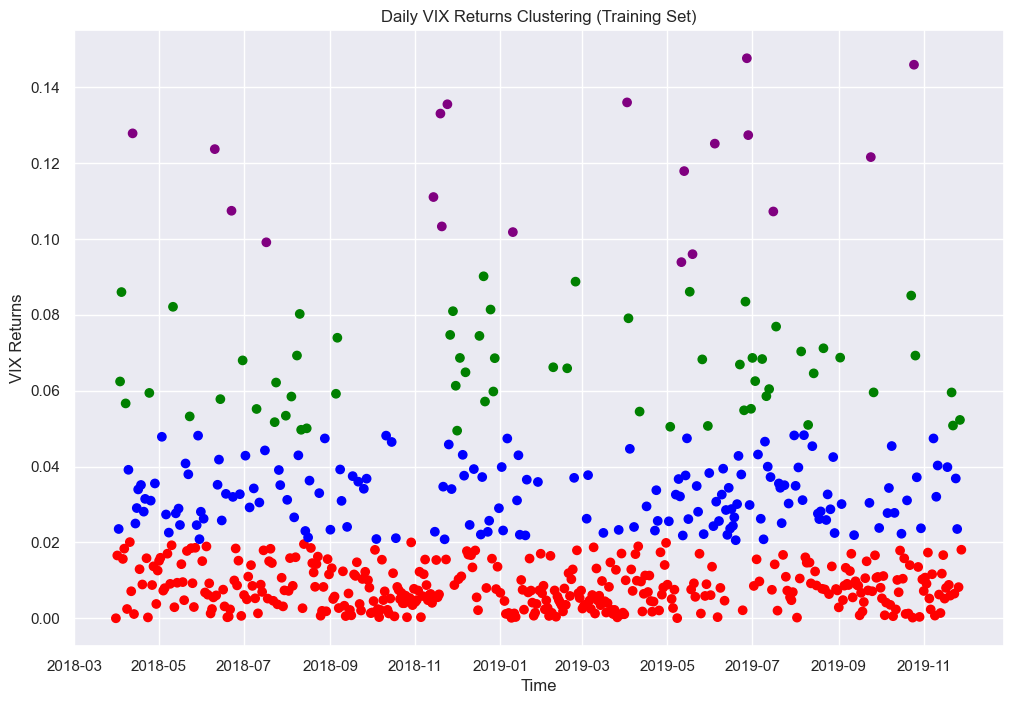

In [25]:
# Plot the clustering result in the training set
import matplotlib
colors = ['red','green','blue','purple']
plt.figure(figsize=(12,8))
plt.scatter(X_train.index, X_train.values, c=train_label, cmap=matplotlib.colors.ListedColormap(colors))
plt.title('Daily VIX Returns Clustering (Training Set)')
plt.xlabel('Time')
plt.ylabel('VIX Returns')

Text(0, 0.5, 'Btc Returns')

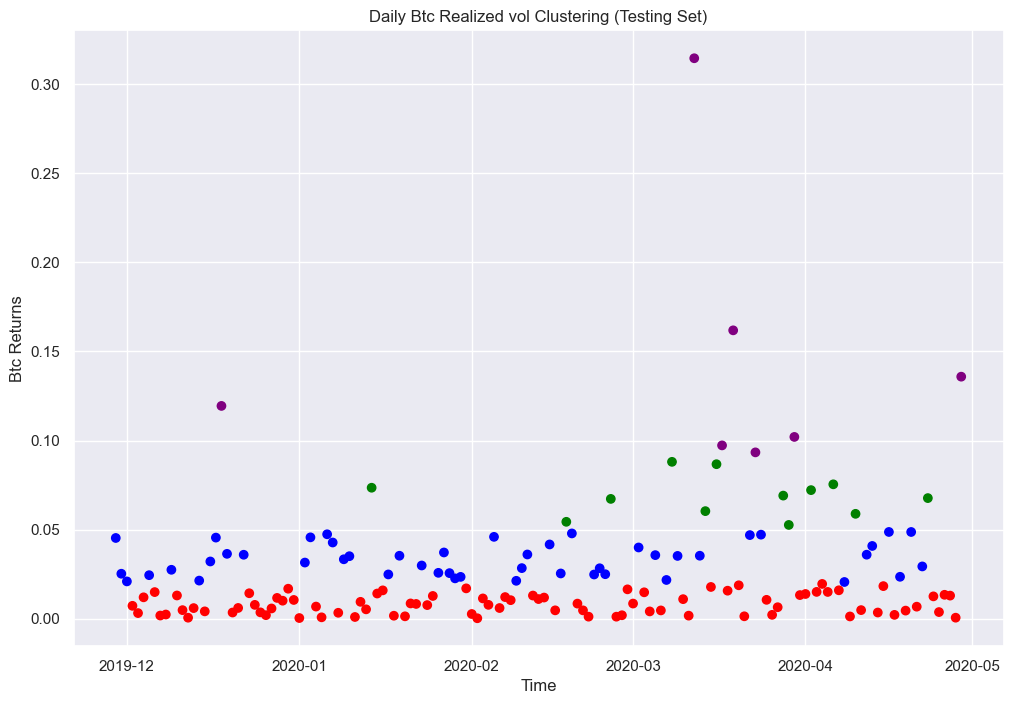

In [26]:
# Plot the clustering result in the testing set
colors = ['red','green','blue','purple']
plt.figure(figsize=(12,8))
plt.scatter(X_test.index, X_test.values, c=test_label, cmap=matplotlib.colors.ListedColormap(colors))
plt.title('Daily Btc Realized vol Clustering (Testing Set)')
plt.xlabel('Time')
plt.ylabel('Btc Returns')

## Fit the GARCH model

In [27]:
# Fit the GARCH(1,1) model to the sp500 returns
garch = arch_model(btc_realized_vola, vol='GARCH', p=2, o=0, q=2, dist='Normal')
# garch = arch_model(sp_ret, vol='GARCH', p=1, o=0, q=1, dist='Normal')
res = garch.fit(last_obs=split_date, disp='off')

# GARCH model summary
print(res.summary())

                      Constant Mean - GARCH Model Results                      
Dep. Variable:     realized_volatility   R-squared:                       0.000
Mean Model:              Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       GARCH   Log-Likelihood:                1367.29
Distribution:                   Normal   AIC:                          -2722.58
Method:             Maximum Likelihood   BIC:                          -2696.11
                                         No. Observations:                  608
Date:                 Tue, Sep 19 2023   Df Residuals:                      607
Time:                         16:20:16   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0227  1.214e-03     18.703  4.67

Text(0.5, 1.0, 'Btc vol vs GARCH Predicted Volatility')

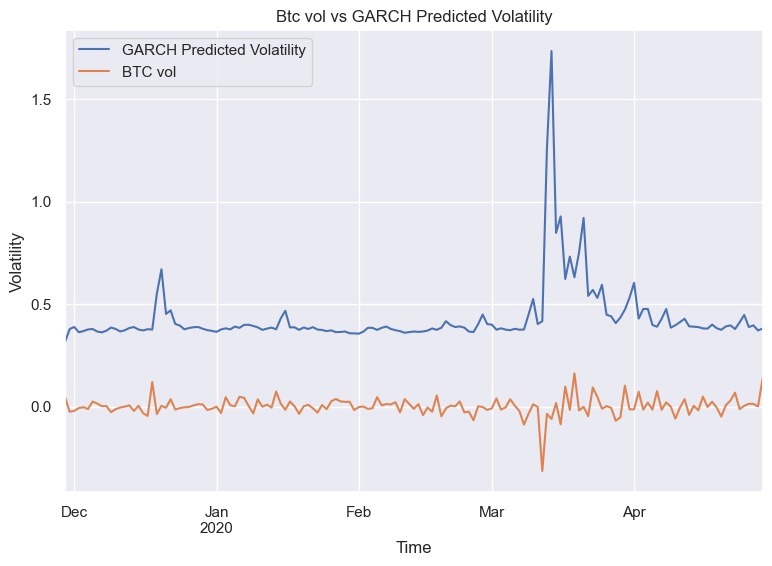

In [28]:
# Use GARCH model to predict conditional volatility
forecasts = res.forecast(horizon=1, start=split_date)
pred_vol = np.sqrt(forecasts.variance[split_date:].shift(1)['h.1'])

# GARCH model parameters
omega = res.params['omega']
alpha = res.params['alpha[1]']
beta = res.params['beta[1]']
mu = res.params['mu']

 # Fill the first one-step forecast 
last_con_vol = res.conditional_volatility[:split_date][-2]
last_resi = res.resid[:split_date][-2]
con_vol = np.sqrt(omega + alpha * last_resi**2 + beta * last_con_vol**2)
pred_vol[split_date] = con_vol

# Annualize the GARCH predicted volatility
p_vol = pred_vol*np.sqrt(252)

# Plot the VIX and GARCH predicted volatility
p_vol.plot(figsize=(9,6))
btc_returns[split_date:].plot(figsize=(9,6))
plt.ylabel('Volatility')
plt.xlabel('Time')
plt.legend(['GARCH Predicted Volatility', 'BTC vol '], loc='upper left')
plt.title('Btc vol vs GARCH Predicted Volatility')

In [21]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score

# predicted label in the testing set
pred_btc_ret = p_vol.pct_change().dropna()
pred_label = best_kmeans.predict(pred_btc_ret.values.reshape(-1,1))
pred_label[pred_label != spike_label] = 0
pred_label[pred_label == spike_label] = 1

# Compute the classification metrics
y_test = true_label
y_score = pred_btc_ret
auc_pr = average_precision_score(y_test, pred_btc_ret)

# print('Average Precision Score:', auc_pr)
print('Recall:', recall_score(y_test, pred_label))
print('Precision:', precision_score(y_test, pred_label))
print(classification_report(y_test, pred_label))

NameError: name 'true_label' is not defined

In [12]:
# Fit the EGARCH model 
egarch = arch_model(btc_returns, p=2, o=0, q=2, vol='EGARCH')
res = egarch.fit(last_obs=split_date, disp='off')

# EGARCH model summary
print(res.summary())

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:            log_returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                1188.35
Distribution:                  Normal   AIC:                          -2364.69
Method:            Maximum Likelihood   BIC:                          -2338.23
                                        No. Observations:                  608
Date:                Tue, Sep 19 2023   Df Residuals:                      607
Time:                        16:14:03   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -1.4421e-03  1.243e-03     -1.161      0.

Text(0.5, 1.0, 'VIX vs EGARCH Predicted Volatility')

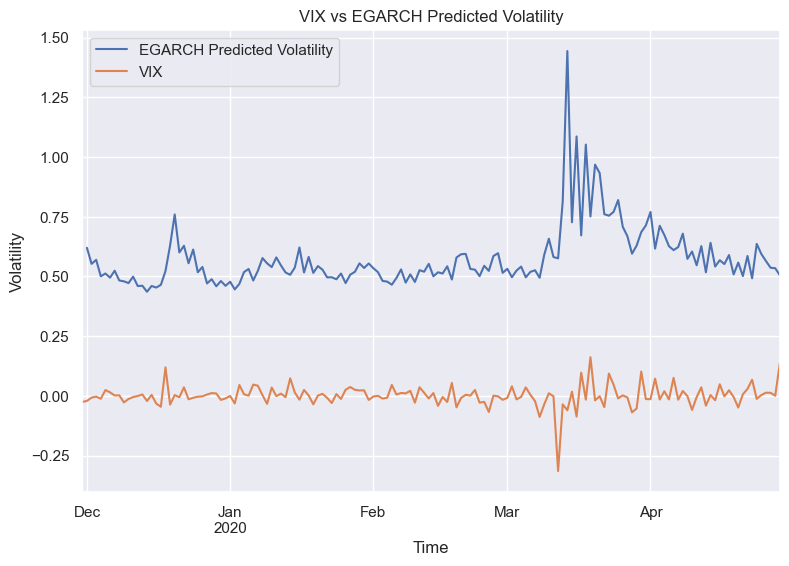

In [23]:
# Use EGARCH model to predict conditional volatility
forecasts = res.forecast(horizon=1, start=split_date, method='bootstrap')
pred_vol = np.sqrt(forecasts.variance[split_date:].shift(1)['h.1'])

# Annualize the EGARCH predicted volatility
p_vol = pred_vol*np.sqrt(252)

# Plot the VIX and GARCH predicted volatility
p_vol.plot(figsize=(9,6))
btc_returns[split_date:].plot(figsize=(9,6))
plt.ylabel('Volatility')
plt.xlabel('Time')
plt.legend(['EGARCH Predicted Volatility', 'VIX'], loc='upper left')
plt.title('VIX vs EGARCH Predicted Volatility')

In [24]:
# predicted label in the testing set
pred_vix_ret = p_vol.pct_change().dropna()
pred_label = best_kmeans.predict(pred_vix_ret.values.reshape(-1,1))
pred_label[pred_label != spike_label] = 0
pred_label[pred_label == spike_label] = 1

# Compute the classification metrics
# y_test = true_label
# y_score = pred_vix_ret
# auc_pr = average_precision_score(y_test, pred_vix_ret)

# print('Average Precision Score:', auc_pr)
print('Recall:', recall_score(y_test, pred_label))
print('Precision:', precision_score(y_test, pred_label))
print(classification_report(y_test, pred_label))

Recall: 0.375
Precision: 0.14754098360655737
              precision    recall  f1-score   support

           0       0.83      0.59      0.69       126
           1       0.15      0.38      0.21        24

    accuracy                           0.55       150
   macro avg       0.49      0.48      0.45       150
weighted avg       0.72      0.55      0.61       150



In [17]:
# AR(1) + GARCH(1,1)
from arch.univariate import ARX
from arch.univariate import GARCH
ar_garch = ARX(sp_ret, lags=[1])
ar_garch.volatility = GARCH(p=1, q=1)
res = ar_garch.fit(last_obs=split_date, disp='off')

# Model summary
print(res.summary())

                           AR - GARCH Model Results                           
Dep. Variable:              Adj Close   R-squared:                       0.001
Mean Model:                        AR   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -7936.34
Distribution:                  Normal   AIC:                           15882.7
Method:            Maximum Likelihood   BIC:                           15916.0
                                        No. Observations:                 5815
Date:                Thu, Nov 29 2018   Df Residuals:                     5810
Time:                        14:07:04   Df Model:                            5
                                   Mean Model                                  
                   coef    std err          t      P>|t|       95.0% Conf. Int.
-------------------------------------------------------------------------------
Const            0.0560  1.083e-02      5.170  2.

Text(0.5, 1.0, 'VIX vs AR-GARCH Predicted Volatility')

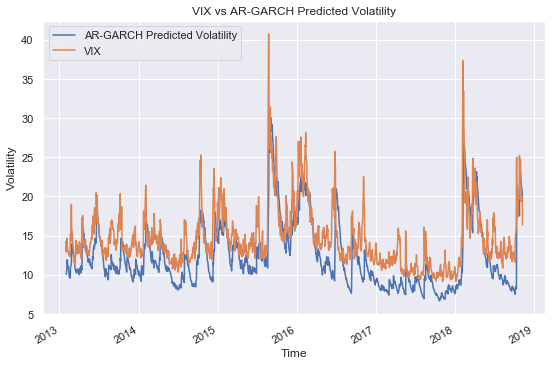

In [18]:
# Use the model to predict conditional volatility
forecasts = res.forecast(horizon=1, start=split_date)
pred_vol = np.sqrt(forecasts.variance[split_date:].shift(1)['h.1'])

# Annualize the predicted volatility
p_vol = pred_vol*np.sqrt(252)

# Plot the VIX and GARCH predicted volatility
p_vol.plot(figsize=(9,6))
vix_data[split_date:].plot(figsize=(9,6))
plt.ylabel('Volatility')
plt.xlabel('Time')
plt.legend(['AR-GARCH Predicted Volatility', 'VIX'], loc='upper left')
plt.title('VIX vs AR-GARCH Predicted Volatility')

In [19]:
# predicted label in the testing set
pred_vix_ret = p_vol.pct_change().dropna()
pred_label = best_kmeans.predict(pred_vix_ret.values.reshape(-1,1))
pred_label[pred_label != spike_label] = 0
pred_label[pred_label == spike_label] = 1

# Compute the classification metrics
# y_test = true_label
# y_score = pred_vix_ret
# auc_pr = average_precision_score(y_test, pred_vix_ret)

# print('Average Precision Score:', auc_pr)
print('Recall:', recall_score(y_test, pred_label))
print('Precision:', precision_score(y_test, pred_label))
print(classification_report(y_test, pred_label))

Recall: 0.07142857142857142
Precision: 0.11864406779661017
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1355
           1       0.12      0.07      0.09        98

   micro avg       0.90      0.90      0.90      1453
   macro avg       0.53      0.52      0.52      1453
weighted avg       0.88      0.90      0.89      1453

